<a href="https://colab.research.google.com/github/mmsamiei/MS-Thesis-Phase2/blob/master/Models/Bakeri/Bakeri.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import IPython
from google.colab import output

display(IPython.display.Javascript('''
  function ClickConnect(){
    console.log("Working"); 
    document.querySelector("colab-connect-button").click() 
  }
  var connect_timer = setInterval(ClickConnect,60000)
'''))

print("Done.")

<IPython.core.display.Javascript object>

Done.


In [2]:
!nvidia-smi

Wed May 13 22:54:51 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.82       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
!cp /content/drive/My\ Drive/Thesis/phase-2/history_sentence_pairs_train.csv ./train.csv
!cp /content/drive/My\ Drive/Thesis/phase-2/history_sentence_pairs_valid.csv ./valid.csv

In [0]:
!pip -q install transformers

In [0]:
from torch.utils.data import Dataset, DataLoader
import os
import torch
import json
from torch.utils.data.sampler import SubsetRandomSampler

from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained('google/bert_uncased_L-4_H-128_A-2')

In [0]:
import random
import pandas as pd
import logging

class MyDataset(Dataset):
    """My dataset."""

    def __init__(self, csv_file, frac=1, split_rate=1, bound=False):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
        """
        self.dialogues = pd.read_csv(csv_file)
        self.dialogues.dropna(inplace=True)
        if bound:
          self.dialogues = self.dialogues[(self.dialogues['history'].apply(len)<280) 
          & (self.dialogues['false_sentence'].apply(len)<280) 
          & (self.dialogues['true_sentence'].apply(len)<280)]
        
        self.dialogues = self.dialogues[self.dialogues.index % split_rate == 0]

        self.dialogues = self.dialogues.sample(frac=frac)
        
        # s = (self.dialogues.true_sentence.str.len() + self.dialogues.history.str.len()).sort_values().index
        # self.dialogues = self.dialogues.reindex(s)
        # s = (self.dialogues.false_sentence.str.len() + self.dialogues.history.str.len()).sort_values().index
        # self.dialogues = self.dialogues.reindex(s)


        self.dialogues.dropna(inplace=True)


    def __len__(self):
        return len(self.dialogues)

    @staticmethod
    def truncuate_join_pair_sentence(sentence1, sentence2, max_len=8):

        """
        truncuate sentence one from head and sentence two from tail
        Args:
            sentence1 (string): first sentence
            sentence2 (string): seconde sentence
        """
        temp1 = tokenizer.encode(sentence1,add_special_tokens=False)
        temp2 = tokenizer.encode(sentence2,add_special_tokens=False)
        ### two above line may cause warning but no problem because we've handle them below
        logging.getLogger("transformers.tokenization_utils").setLevel(logging.ERROR)
        seq_1 = temp1
        seq_2 = temp2
        num_tokens_to_remove = len(temp1) + len(temp2) + 3 - max_len
        if num_tokens_to_remove > 0 :
            seq_1, seq_2, _ = tokenizer.truncate_sequences(temp1[::-1],temp2, num_tokens_to_remove=num_tokens_to_remove)
            seq_1.reverse()
        result_list = [tokenizer.cls_token_id]+seq_1+[tokenizer.sep_token_id]+seq_2+[tokenizer.sep_token_id]
        token_type_ids = [0] * (len(seq_1) + 2) + [1] * (len(seq_2) + 1)
        return result_list, token_type_ids


    def __getitem__(self, idx):
      
        
        history = self.dialogues.iloc[idx].history
        true_sentence = self.dialogues.iloc[idx].true_sentence
        false_sentence = self.dialogues.iloc[idx].false_sentence


        true_pair, true_pair_segments = MyDataset.truncuate_join_pair_sentence(history, true_sentence)
        false_pair, false_pair_segments  = MyDataset.truncuate_join_pair_sentence(history, false_sentence)
        
        

        true_pair = torch.LongTensor(true_pair)
        false_pair = torch.LongTensor(false_pair)

        true_pair_segments = torch.LongTensor(true_pair_segments)
        false_pair_segments = torch.LongTensor(false_pair_segments)


        sample = {'true_pair': true_pair, 'false_pair': false_pair,
                  'true_pair_segments': true_pair_segments,
                  'false_pair_segments': false_pair_segments}

        return sample

In [86]:
MyDataset.truncuate_join_pair_sentence("H I S T O R Y", "S E N T E N C E")

([101, 1051, 1054, 1061, 102, 1055, 1041, 102], [0, 0, 0, 0, 0, 1, 1, 1])

In [84]:
train_dataset = MyDataset('train.csv', split_rate=1, bound=True)
valid_dataset = MyDataset('valid.csv', split_rate=3)
overfit_dataset = MyDataset('train.csv', split_rate=1000)
print(len(train_dataset))
print(len(valid_dataset))
print(len(overfit_dataset))

1178289
49143
2776


In [39]:
from tqdm.auto import tqdm

def my_collate_fn(batch):

  len_batch = len(batch)

  
  max_len_true_pair = max([len(data['true_pair']) for data in batch])
  max_len_false_pair = max([len(data['false_pair']) for data in batch])
  
  padding_ind = 0 ## for bert is 0
  result_true_pair = torch.zeros(len_batch, max_len_true_pair)
  result_false_pair = torch.zeros(len_batch, max_len_false_pair)
  
  result_true_segment = torch.zeros(len_batch, max_len_true_pair)
  result_false_segment = torch.zeros(len_batch, max_len_false_pair)

  for i, data in enumerate(batch):
    p1 = len(data['true_pair'])
    result_true_pair[i, :p1] = data['true_pair']
    p2 = len(data['false_pair'])
    result_false_pair[i, :p2] = data['false_pair']

    p3 = len(data['true_pair_segments'])
    result_true_segment[i, :p3] = data['true_pair_segments']

    p4 = len(data['false_pair_segments'])
    result_false_segment[i, :p4] = data['false_pair_segments']


  return result_true_pair.long(), result_false_pair.long()

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32,
                                             shuffle=True, collate_fn=my_collate_fn,
                                           num_workers=1)

valid_sampler = torch.utils.data.SequentialSampler(valid_dataset)
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=32, sampler=valid_sampler,
                                             shuffle=False, collate_fn=my_collate_fn, num_workers=1)

overfit_loader = torch.utils.data.DataLoader(overfit_dataset, batch_size=32,
                                             shuffle=True, collate_fn=my_collate_fn,
                                           num_workers=1)

i = 0 
for batch_idx, batch  in tqdm(enumerate(train_loader)):
  true_batch, false_batch = batch
  print(false_batch.shape)
  i += 1 
  if(i==4):
    break

torch.Size([32, 106])
torch.Size([32, 97])
torch.Size([32, 116])
torch.Size([32, 137])


In [54]:
import os

import torch
import torch.nn as nn
from torch.nn import functional as F
from torch.utils.data import DataLoader
from torchvision import transforms
from transformers import AutoModel

class Model(nn.Module):
  def __init__(self):
    super(Model, self).__init__()

    self.bert = AutoModel.from_pretrained("google/bert_uncased_L-4_H-128_A-2")
    self.fc = nn.Linear(128,1)
    self.activation = nn.Tanh()

    for p in self.bert.embeddings.parameters():
      p.requires_grad = False
    
    nn.init.xavier_normal_(self.fc.weight)
  
  def forward(self, x):
        temp = x
        temp = self.bert(temp)[0]
        ## temp = [batch, len, hid_size]
        temp = temp[:,0,:]
        temp = self.fc(temp)
        temp = self.activation(temp)
        temp = (temp - (-1))/2 
        return temp

dev = torch.device('cuda')
model = Model().to(dev)


# x = torch.LongTensor(200, 40).random_(1,1000).to(dev)
# print(model(x).shape)


def count_parameters(model): return sum(p.numel() for p in model.parameters() if p.requires_grad)
print(count_parameters(model))

809729


In [0]:
class NoamOpt:
    "Optim wrapper that implements rate."
    def __init__(self, model_size, factor, warmup, optimizer):
        self.optimizer = optimizer
        self._step = 0
        self.warmup = warmup
        self.factor = factor
        self.model_size = model_size
        self._rate = 0
        
    def step(self):
        "Update parameters and rate"
        self._step += 1
        rate = self.rate()
        for p in self.optimizer.param_groups:
            p['lr'] = rate
        self._rate = rate
        self.optimizer.step()
        
    def rate(self, step = None):
        "Implement `lrate` above"
        if step is None:
            step = self._step
        return self.factor * \
            (self.model_size ** (-0.5) *
            min(step ** (-0.5), step * self.warmup ** (-1.5)))
    
    def zero_grad(self):
        self.optimizer.zero_grad()

In [0]:
optimizer = NoamOpt(128, 1, 4000,
            torch.optim.Adam(model.parameters(), lr=0, betas=(0.9, 0.98), eps=1e-9))

#optimizer = torch.optim.Adam(model.parameters(), lr=3e-5)

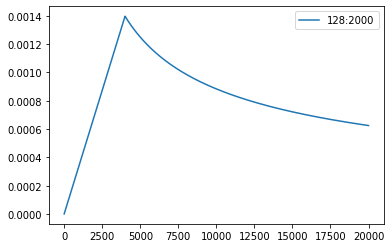

In [57]:
import matplotlib.pyplot as plt
import numpy as np
plt.plot(np.arange(1, 20000), [optimizer.rate(i) for i in range(1, 20000)])
plt.legend(["128:2000", "512:8000", "256:4000"])

In [0]:
import torch.nn.functional as F

def mahdi_loss(true_sml, false_sml):
  eps = 1e-8
  loss = torch.mean( -torch.log(true_sml+eps)-torch.log(1-false_sml+eps))
  return loss

In [0]:
from tqdm.auto import tqdm

def train_step(batch_idx, batch):
  true_pairs, false_pairs = batch
  true_pairs = true_pairs.to(dev)
  false_pairs = false_pairs.to(dev)
  optimizer.zero_grad()
  true_sml = model(true_pairs)
  false_sml = model(false_pairs)
  loss = mahdi_loss(true_sml, false_sml)
  loss.backward()
  optimizer.step()
  del true_pairs
  del false_pairs
  return loss.item()

def valid_step(batch_idx, batch):
  true_pairs, false_pairs = batch
  true_pairs = true_pairs.to(dev)
  false_pairs = false_pairs.to(dev)
  true_sml = model(true_pairs)
  false_sml = model(false_pairs)
  z = true_sml - false_sml
  num_err = z[z<0].size()[0]
  return num_err

def valid_loop(valid_loader):
  total_error = 0
  model.eval()
  for batch_idx, batch in tqdm(enumerate(valid_loader),  total=len(valid_loader)):
    total_error += valid_step(batch_idx, batch)
  return total_error / len(valid_dataset)

In [0]:
new_learning = True
if new_learning:
  model_dir = "/content/drive/My Drive/Thesis/phase-2/Models/bakeri/"
  step = 0
  log_list = []

In [17]:
## if continue learning:
#!wget -q https://github.com/mmsamiei/MS-Thesis-Phase2/raw/master/Models/hashemi_16000steps.model
model_dir = "/content/drive/My Drive/Thesis/phase-2/Models/bakeri/"
checkpoint = torch.load(model_dir+'bakeri_38000steps.model')
step = checkpoint['log_list'][-1]['step']
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
optimizer._step = step
log_list = checkpoint['log_list']
new_learning = False
print(step)

38000


In [61]:
from tqdm.auto import tqdm

OVERFIT_EPOCH = 100
hyper_parameter_choosing = True
if hyper_parameter_choosing:
  epoch_num = 0
  while epoch_num < OVERFIT_EPOCH:
    model.train()
    epoch_loss = []
    for batch_idx, batch in tqdm(enumerate(iter(overfit_loader)), total=len(overfit_loader)):
      step_loss = train_step(batch_idx, batch)
      epoch_loss.append(step_loss)
    print("Epoch {} Loss is {}".format( epoch_num,sum(epoch_loss) /  len(epoch_loss)  ))
    epoch_num += 1


Epoch 0 Loss is 1.5753152493772835



Epoch 1 Loss is 1.4415812218326263



Epoch 2 Loss is 1.3742303889373253



Epoch 3 Loss is 1.3031817167654804



Epoch 4 Loss is 1.2626864649783607



Epoch 5 Loss is 1.1854560608151314



Epoch 6 Loss is 1.1330524778914177



Epoch 7 Loss is 1.076763176369941



Epoch 8 Loss is 1.0436855664198426



Epoch 9 Loss is 1.0005832773515548



Epoch 10 Loss is 0.9871065822140924



Epoch 11 Loss is 0.9347628396132897



Epoch 12 Loss is 0.9258420323503429



Epoch 13 Loss is 0.8900417952701963



Epoch 14 Loss is 0.889696161637361



Epoch 15 Loss is 0.8359962016686626



Epoch 16 Loss is 0.7924498223710335



Epoch 17 Loss is 0.8270756890033854



Epoch 18 Loss is 0.7878811205255574



Epoch 19 Loss is 0.7787681091790912



Epoch 20 Loss is 0.7544418878253849



Epoch 21 Loss is 0.736301256664868



Epoch 22 Loss is 0.743112756945621



Epoch 23 Loss is 0.7190861667709789



Epoch 24 Loss is 0.7288259939215649



Epoch 25 Loss is 0.6962858465896256



Epoch 26 Loss is 0.6751012613718537



Epoch 27 Loss is 0.6956224763530424



Epoch 28 Loss is 0.6751182017655208



Epoch 29 Loss is 0.6824290327642156



Epoch 30 Loss is 0.6872466504573822



Epoch 31 Loss is 0.7050138369373892



Epoch 32 Loss is 0.6872166919297186



Epoch 33 Loss is 0.6847346736781899



Epoch 34 Loss is 0.6765182121046658



Epoch 35 Loss is 0.6835385112241766



Epoch 36 Loss is 0.6501959928835945



Epoch 37 Loss is 0.6731282825442566



Epoch 38 Loss is 0.6552214646476439



Epoch 39 Loss is 0.6528072326347746



Epoch 40 Loss is 0.6540863856501963



Epoch 41 Loss is 0.6798111858039066



Epoch 42 Loss is 0.6659986976234392



Epoch 43 Loss is 0.6745367714728432



Epoch 44 Loss is 0.6460307768021507



Epoch 45 Loss is 0.6410088765210119



Epoch 46 Loss is 0.6328802184126843



Epoch 47 Loss is 0.6814065746877386



Epoch 48 Loss is 0.6853229609029047



Epoch 49 Loss is 0.6705228480799444



Epoch 50 Loss is 0.6443044598075165



Epoch 51 Loss is 0.6576313989600916



Epoch 52 Loss is 0.5869558487815418



Epoch 53 Loss is 0.5930303600670277



Epoch 54 Loss is 0.5212948373679457



Epoch 55 Loss is 0.5295784081193222



Epoch 56 Loss is 0.47009455780873355



Epoch 57 Loss is 0.5386794243735828



Epoch 58 Loss is 0.4541802509077664



Epoch 59 Loss is 0.4455336411108916



Epoch 60 Loss is 0.39915244092886476



Epoch 61 Loss is 0.42704482188169984



Epoch 62 Loss is 0.4041108826453658



Epoch 63 Loss is 0.3983231731529894



Epoch 64 Loss is 0.3614333426130229



Epoch 65 Loss is 0.3838718956571886



Epoch 66 Loss is 0.3551804777877084



Epoch 67 Loss is 0.34762930767289524



Epoch 68 Loss is 0.31210877061232756



Epoch 69 Loss is 0.3330604590732476



Epoch 70 Loss is 0.315974124974903



Epoch 71 Loss is 0.303810415939353



Epoch 72 Loss is 0.28551772112647694



Epoch 73 Loss is 0.2668687051654547



Epoch 74 Loss is 0.2933487757269678



Epoch 75 Loss is 0.28617808376920634



Epoch 76 Loss is 0.2960080348554699



Epoch 77 Loss is 0.2615099501335758



Epoch 78 Loss is 0.26830371088166344



Epoch 79 Loss is 0.251337463828339



Epoch 80 Loss is 0.2466737717047505



Epoch 81 Loss is 0.24821708599726358



Epoch 82 Loss is 0.24882868142134842



Epoch 83 Loss is 0.2372334143468018



Epoch 84 Loss is 0.23660459189579405



Epoch 85 Loss is 0.22022994950242425



Epoch 86 Loss is 0.2528114124875644



Epoch 87 Loss is 0.20666080015315408



Epoch 88 Loss is 0.23600856604418535



Epoch 89 Loss is 0.20481830330073147



Epoch 90 Loss is 0.2153372443655784



Epoch 91 Loss is 0.18274105295281987



Epoch 92 Loss is 0.180418205072825



Epoch 93 Loss is 0.2031483145366455



Epoch 94 Loss is 0.18854377894052143



Epoch 95 Loss is 0.1736508414320562



Epoch 96 Loss is 0.20480657287541476



Epoch 97 Loss is 0.2237903831376769



Epoch 98 Loss is 0.17865167708061208



Epoch 99 Loss is 0.16615005755989715


In [47]:
from tqdm.auto import tqdm

MAX_STEP = 1000
STEP_SAVE = 100000 
STEP_CHECK = 100000
step_num = step + 1
log_list = log_list ### Check if new learning or not
print(step_num)
while step_num <= MAX_STEP:
  model.train()
  for batch_idx, batch in tqdm(enumerate(iter(train_loader)), total=len(train_loader)):
    step_loss = train_step(batch_idx, batch)
    log = {'step':step_num, 'train_loss':step_loss}

    if(step_num % STEP_CHECK == 0):
      valid_error = valid_loop(valid_loader)
      print("Error rate: {} at step {}".format(valid_error, step_num))  
      log['valid_error'] = valid_error
      log_list.append(log)
      model.train()
      torch.save({
            'model_state_dict': model.state_dict(),
            'log_list': log_list,
            'optimizer_state_dict': optimizer.optimizer.state_dict() 
            }, model_dir+'bakeri_{}steps.model'.format(step_num))
      step_num += 1
      continue
    
    log_list.append(log)
    if(step_num % STEP_SAVE == 0):
      torch.save({
            'model_state_dict': model.state_dict(),
            'log_list': log_list,
            'optimizer_state_dict': optimizer.optimizer.state_dict()
            }, model_dir+'bakeri_{}steps.model'.format(step_num))
    step_num += 1


1


KeyboardInterrupt: ignored

In [0]:
checkpoint = torch.load(model_dir+'bagheri_50000steps.model')
step = checkpoint['log_list'][-1]['step']
model.load_state_dict(checkpoint['model_state_dict'])
model = model.eval()

In [0]:
checkpoint['log_list'][-100:]

[{'step': 49901, 'train_loss': 0.8324142694473267},
 {'step': 49902, 'train_loss': 0.920741081237793},
 {'step': 49903, 'train_loss': 0.8677593469619751},
 {'step': 49904, 'train_loss': 0.8985825777053833},
 {'step': 49905, 'train_loss': 0.8031026124954224},
 {'step': 49906, 'train_loss': 0.9139066338539124},
 {'step': 49907, 'train_loss': 0.9318299293518066},
 {'step': 49908, 'train_loss': 0.683719277381897},
 {'step': 49909, 'train_loss': 0.8610292673110962},
 {'step': 49910, 'train_loss': 0.8241980075836182},
 {'step': 49911, 'train_loss': 0.798753559589386},
 {'step': 49912, 'train_loss': 0.8694151639938354},
 {'step': 49913, 'train_loss': 0.790998101234436},
 {'step': 49914, 'train_loss': 0.7303371429443359},
 {'step': 49915, 'train_loss': 0.9581151604652405},
 {'step': 49916, 'train_loss': 0.8623735904693604},
 {'step': 49917, 'train_loss': 0.7973780632019043},
 {'step': 49918, 'train_loss': 0.807317852973938},
 {'step': 49919, 'train_loss': 0.8690530061721802},
 {'step': 49920, 

In [0]:
test_df = pd.read_csv('/content/drive/My Drive/Thesis/phase-2/history_sentence_pairs_test_unseen.csv')
test_df.fillna(' ', inplace=True)
mrr_df = pd.DataFrame(data=test_df.history.unique(), columns=['history'])
mrr_df['correct_rank'] = 0

In [0]:
test_df_gb = test_df.groupby(['history','true_sentence'])
for case in tqdm(test_df_gb):
  history = case[0][0]
  true_sentence = case[0][1]
  true_pair = torch.LongTensor(MyDataset.truncuate_join_pair_sentence(history, true_sentence)).reshape(1, -1).to(dev)
  true_sml = model(true_pair)
  case_df = case[1]
  for false_sentence in case_df['false_sentence']:
    false_pair = torch.LongTensor(MyDataset.truncuate_join_pair_sentence(history, false_sentence)).reshape(1, -1).to(dev)
    false_sml = model(false_pair)
    if(true_sml.item() < false_sml.item()):
      mrr_df.loc[mrr_df['history']==history, 'correct_rank'] += 1

In [0]:
len(mrr_df[ mrr_df['correct_rank'] < 5 ]) / len(mrr_df)

0.5211018448319434